In [142]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def validFiles(files):
    validFiles = []
    for file in files:
        if os.path.exists(file):
            validFiles.append(file)
    return validFiles


# Read all Files

In [143]:
def getISScheme(studyTitle):
    return studyTitle.split('_')[0]

def getCTScheme(studyTitle):
    # remove everything before the first _ but keep the rest including "_"
    split = studyTitle.split('_')
    return '_'.join(split[1:])

# basic definitions
idleSlopeSchemes = ['Static', 'CMI', 'SI', 'NC']
crossTrafficSchemes = ['NoCT', 'NoCT_NoPCTRes', 'BECT', 'BECT_NoPCTRes', 'PCT']
studyTitles = []
for idleSlopeScheme in idleSlopeSchemes:
    for crossTrafficScheme in crossTrafficSchemes:
        if ((idleSlopeScheme == 'Static' and crossTrafficScheme == 'NoCT_NoPCTRes') 
            or (idleSlopeScheme == 'Static' and crossTrafficScheme == 'BECT_NoPCTRes')
            or (idleSlopeScheme == 'NC' and crossTrafficScheme == 'NoCT_NoPCTRes') 
            or (idleSlopeScheme == 'NC' and crossTrafficScheme == 'BECT_NoPCTRes')):
            continue
        studyTitles.append(idleSlopeScheme + '_' + crossTrafficScheme)
studyTitles

['Static_NoCT',
 'Static_BECT',
 'Static_PCT',
 'CMI_NoCT',
 'CMI_NoCT_NoPCTRes',
 'CMI_BECT',
 'CMI_BECT_NoPCTRes',
 'CMI_PCT',
 'SI_NoCT',
 'SI_NoCT_NoPCTRes',
 'SI_BECT',
 'SI_BECT_NoPCTRes',
 'SI_PCT',
 'NC_NoCT',
 'NC_BECT',
 'NC_PCT']

## Read Simulation Results
Open the Study as an anf-File and select the relevant data in OMNeT++ IDE.
Right click and select "Export Data" -> "JSON" -> Select Use NumPy arrays, and other settings specified below.

Studies are formed for all IdleSlope schemes:
- Static
- CMI 
- Stream Interval (SI)
- Network Calculus (NC) -- from DYRECTsn Framework

For all schemes the following permutations are executed:
- NoCT
- NoCT_NoPCTRes (not for static scheme, as it is not applicable)
- BECT
- BECT_NoPCTRes (not for static scheme, as it is not applicable)
- PCT

The %STUDY% is formed by the scheme and the permutation, e.g. `Static_NoCT` or `SI_BECT_NoPCTRes`.

Table for the settings, all results are Vectors
| Module Filter | Result Name | Target File | Start Time | End Time |
|---------------|-------------|-------------|------------|----------|
| `**.aggregateSwitch.etherMAC[0].**.transmissionSelectionAlgorithm[7]` | reservedBandwidth | `sim/%STUDY%_AggregateIdleSlopes.json` | 0s | 0.2s |
| `**.stageSwitch[*].etherMAC[1].**.transmissionSelectionAlgorithm[7]` | reservedBandwidth | `sim/%STUDY%_StageIdleSlopes.json` | 0s | 0.2s |
| `**.aggregateSwitch.etherMAC[0].**.queue[7]` | delay | `sim/%STUDY%_AggregateDelay.json` | 0.1s | 0.3s |
| `**.aggregateSwitch.etherMAC[0].**.queue[7]` | length | `sim/%STUDY%_AggregateQueue.json` | 0.1s | 0.3s |

SI_NoCT_NoPCTRes_AggregateIdleSlopes.json
SI_NoCT_NoPCTRes_StageIdleSlopes.json
SI_NoCT_NoPCTRes_AggregateDelay.json
SI_NoCT_NoPCTRes_AggregateQueue.json

In [144]:
def buildSimFileName(studyTitle, valueName):
    return 'sim/' + studyTitle + "_" + valueName + '.json'

def getValueNameFromSimFileName(simFileName):
    split = simFileName.split('/')[-1].split('.')[0].split('_')
    return split[-1]

def getStudyTitleFromSimFileName(simFileName):
    split = simFileName.split('/')[-1].split('.')[0].split('_')
    return '_'.join(split[:-1])


In [145]:
simAggregateSlopeFiles = []
simStageSlopeFiles = []
simQueueFiles = []
simDelayFiles = []
for studyTitle in studyTitles:
    simAggregateSlopeFiles.append(buildSimFileName(studyTitle, 'AggregateIdleSlopes'))
    simStageSlopeFiles.append(buildSimFileName(studyTitle, 'StageIdleSlopes'))
    simQueueFiles.append(buildSimFileName(studyTitle, 'AggregateQueue'))
    simDelayFiles.append(buildSimFileName(studyTitle, 'AggregateDelay'))

# check if the files exist and remove the ones that do not from the list
simAggregateSlopeFiles = validFiles(simAggregateSlopeFiles)
simStageSlopeFiles = validFiles(simStageSlopeFiles)
simQueueFiles = validFiles(simQueueFiles)
simDelayFiles = validFiles(simDelayFiles)

print ("valid sim files found:")
print (simAggregateSlopeFiles)
print (simStageSlopeFiles)
print (simQueueFiles)
print (simDelayFiles)

valid sim files found:
['sim/CMI_NoCT_AggregateIdleSlopes.json', 'sim/CMI_NoCT_NoPCTRes_AggregateIdleSlopes.json', 'sim/SI_NoCT_AggregateIdleSlopes.json', 'sim/SI_NoCT_NoPCTRes_AggregateIdleSlopes.json']
['sim/CMI_NoCT_StageIdleSlopes.json', 'sim/CMI_NoCT_NoPCTRes_StageIdleSlopes.json', 'sim/SI_NoCT_StageIdleSlopes.json', 'sim/SI_NoCT_NoPCTRes_StageIdleSlopes.json']
['sim/CMI_NoCT_AggregateQueue.json', 'sim/CMI_NoCT_NoPCTRes_AggregateQueue.json', 'sim/SI_NoCT_AggregateQueue.json', 'sim/SI_NoCT_NoPCTRes_AggregateQueue.json']
['sim/CMI_NoCT_AggregateDelay.json', 'sim/CMI_NoCT_NoPCTRes_AggregateDelay.json', 'sim/SI_NoCT_AggregateDelay.json', 'sim/SI_NoCT_NoPCTRes_AggregateDelay.json']


### Reserverd Bandwidth for Aggregate and Stage Switches

In [146]:
def getMaxIdleSlopesForSimStudy(simFile, returnFirst=True):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        stages = int(sim[study]["itervars"]["S"])
        inputLinks = int(sim[study]["itervars"]["IL"])
        maxIdleSlope = 0
        for vector in sim[study]["vectors"]:
            if "reservedBandwidth" in vector["name"]:
                maxIdleSlope = np.max([np.max(vector["value"]),maxIdleSlope])
                if returnFirst:
                    break
        results[(inputLinks,stages)] = maxIdleSlope
    return results

def getMaxSlopesForStudyFiles(simFiles, returnFirst=True):
    results = dict()
    for simFile in simFiles:
        study = getStudyTitleFromSimFileName(simFile)
        isScheme = getISScheme(study)
        ctScheme = getCTScheme(study)
        if isScheme not in results:
            results[isScheme] = dict()
        results[isScheme][ctScheme] = getMaxIdleSlopesForSimStudy(simFile, returnFirst)
    return results

In [147]:
simAggregateIdleSlopes = getMaxSlopesForStudyFiles(simAggregateSlopeFiles, returnFirst=True)
print(simAggregateIdleSlopes)

{'CMI': {'NoCT': {(10, 8): 75520000, (10, 9): 75520000, (10, 14): 75520000, (10, 1): 75520000, (10, 10): 75520000, (10, 13): 75520000, (10, 12): 75520000, (10, 17): 75520000, (10, 2): 75520000, (10, 20): 75520000, (10, 3): 75520000, (10, 4): 75520000, (10, 16): 75520000, (10, 18): 75520000, (10, 11): 75520000, (10, 5): 75520000, (10, 19): 75520000, (10, 6): 75520000, (10, 15): 75520000, (10, 7): 75520000, (2, 11): 75008000, (11, 15): 75328000, (11, 13): 75328000, (11, 16): 75328000, (11, 5): 75328000, (12, 1): 75264000, (12, 17): 75264000, (11, 9): 75328000, (11, 2): 75328000, (12, 3): 75264000, (12, 7): 75264000, (11, 17): 75328000, (13, 11): 75712000, (13, 7): 75712000, (2, 12): 75008000, (11, 20): 75328000, (12, 8): 75264000, (13, 14): 75712000, (13, 8): 75712000, (12, 5): 75264000, (12, 12): 75264000, (12, 10): 75264000, (12, 15): 75264000, (12, 2): 75264000, (12, 20): 75264000, (11, 11): 75328000, (11, 12): 75328000, (11, 18): 75328000, (11, 3): 75328000, (11, 6): 75328000, (13, 1

In [148]:
simStageIdleSlopes = getMaxSlopesForStudyFiles(simStageSlopeFiles, returnFirst=False)
print(simStageIdleSlopes)

{'CMI': {'NoCT': {(10, 8): 75072000, (10, 9): 75072000, (10, 14): 75072000, (10, 1): 75072000, (10, 10): 75072000, (10, 13): 75072000, (10, 12): 75072000, (10, 17): 75072000, (10, 2): 75072000, (10, 20): 75072000, (10, 3): 75072000, (10, 4): 75072000, (10, 16): 75072000, (10, 18): 75072000, (10, 11): 75072000, (10, 5): 75072000, (10, 19): 75072000, (10, 6): 75072000, (10, 15): 75072000, (10, 7): 75072000, (2, 11): 75008000, (11, 15): 75072000, (11, 13): 75072000, (11, 16): 75072000, (11, 5): 75072000, (12, 1): 75072000, (12, 17): 75072000, (11, 9): 75072000, (11, 2): 75072000, (12, 3): 75072000, (12, 7): 75072000, (11, 17): 75072000, (13, 11): 75072000, (13, 7): 75072000, (2, 12): 75008000, (11, 20): 75072000, (12, 8): 75072000, (13, 14): 75072000, (13, 8): 75072000, (12, 5): 75072000, (12, 12): 75072000, (12, 10): 75072000, (12, 15): 75072000, (12, 2): 75072000, (12, 20): 81344000, (11, 11): 75072000, (11, 12): 75072000, (11, 18): 75072000, (11, 3): 75072000, (11, 6): 75072000, (13, 1

### Aggregate Switch Max Queue Length

In [149]:
def getMaxQueueForSimStudy(simFile, returnFirst=True):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        stages = int(sim[study]["itervars"]["S"])
        inputLinks = int(sim[study]["itervars"]["IL"])
        maxQueue = 0
        for vector in sim[study]["vectors"]:
            if "length" in vector["name"]:
                maxQueue = np.max([np.max(vector["value"]),maxQueue])
                if returnFirst:
                    break
        results[(inputLinks,stages)] = maxQueue
    return results

def getMaxQueueForStudyFiles(simFiles, returnFirst=True):
    results = dict()
    for simFile in simFiles:
        study = getStudyTitleFromSimFileName(simFile)
        isScheme = getISScheme(study)
        ctScheme = getCTScheme(study)
        if isScheme not in results:
            results[isScheme] = dict()
        results[isScheme][ctScheme] = getMaxQueueForSimStudy(simFile, returnFirst)
    return results

In [150]:
simAggregateQueues = getMaxQueueForStudyFiles(simQueueFiles, returnFirst=True)
print(simAggregateQueues)

{'CMI': {'NoCT': {(10, 8): 18, (10, 9): 18, (10, 14): 19, (10, 1): 18, (10, 10): 18, (10, 13): 18, (10, 12): 18, (10, 17): 17, (10, 2): 18, (10, 20): 19, (10, 3): 18, (10, 4): 18, (10, 16): 18, (10, 18): 18, (10, 11): 18, (10, 5): 18, (10, 19): 18, (10, 6): 18, (10, 15): 18, (10, 7): 18, (2, 11): 3, (11, 15): 21, (11, 13): 20, (11, 16): 20, (11, 5): 20, (12, 1): 22, (12, 17): 22, (11, 9): 20, (11, 2): 20, (12, 3): 22, (12, 7): 22, (11, 17): 19, (13, 11): 23, (13, 7): 23, (2, 12): 3, (11, 20): 21, (12, 8): 21, (13, 14): 24, (13, 8): 24, (12, 5): 22, (12, 12): 22, (12, 10): 22, (12, 15): 22, (12, 2): 22, (12, 20): 21, (11, 11): 20, (11, 12): 19, (11, 18): 19, (11, 3): 20, (11, 6): 20, (13, 13): 23, (12, 6): 22, (12, 4): 22, (11, 14): 20, (13, 15): 23, (12, 18): 21, (11, 1): 20, (13, 16): 22, (12, 19): 20, (13, 17): 23, (11, 10): 21, (12, 14): 22, (11, 8): 21, (13, 18): 22, (11, 19): 19, (13, 19): 22, (12, 16): 22, (13, 20): 24, (12, 13): 22, (13, 3): 24, (13, 4): 24, (11, 7): 20, (12, 11

### Aggregate Switch Max Queue Delay

In [151]:
def getMaxDelayForSimStudy(simFile, returnFirst=True):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        stages = int(sim[study]["itervars"]["S"])
        inputLinks = int(sim[study]["itervars"]["IL"])
        maxDelay = 0
        for vector in sim[study]["vectors"]:
            if "delay" in vector["name"]:
                maxDelay = np.max([np.max(vector["value"]),maxDelay])
                if returnFirst:
                    break
        results[(inputLinks,stages)] = maxDelay
    return results

def getMaxDelayForStudyFiles(simFiles, returnFirst=True):
    results = dict()
    for simFile in simFiles:
        study = getStudyTitleFromSimFileName(simFile)
        isScheme = getISScheme(study)
        ctScheme = getCTScheme(study)
        if isScheme not in results:
            results[isScheme] = dict()
        results[isScheme][ctScheme] = getMaxDelayForSimStudy(simFile, returnFirst)
    return results

In [152]:
simAggregateDelays = getMaxDelayForStudyFiles(simDelayFiles, returnFirst=False)
print(simAggregateDelays)

{'CMI': {'NoCT': {(10, 8): 0.000225615, (10, 9): 0.00022382, (10, 14): 0.00022078, (10, 1): 0.0001985, (10, 10): 0.00022382, (10, 13): 0.00022731500000000001, (10, 12): 0.000221995, (10, 17): 0.00021991500000000002, (10, 2): 0.0001985, (10, 20): 0.000219535, (10, 3): 0.0001985, (10, 4): 0.00022923500000000002, (10, 16): 0.000218375, (10, 18): 0.00021774, (10, 11): 0.00022382, (10, 5): 0.00022686, (10, 19): 0.00021774, (10, 6): 0.00022686, (10, 15): 0.00022078, (10, 7): 0.00022686, (2, 11): 0.00016382000000000001, (11, 15): 0.00021936000000000001, (11, 13): 0.000224555, (11, 16): 0.00021932, (11, 5): 0.00022764, (12, 1): 0.00019878, (12, 17): 0.00021794000000000002, (11, 9): 0.00022778000000000002, (11, 2): 0.00019872, (12, 3): 0.00019878, (12, 7): 0.00022626, (11, 17): 0.00021932, (13, 11): 0.00022392, (13, 7): 0.00022624, (2, 12): 0.00015491500000000002, (11, 20): 0.00021652, (12, 8): 0.00022554, (13, 14): 0.0002216, (13, 8): 0.00022879999999999998, (12, 5): 0.0002281, (12, 12): 0.000

## Read Q-Formula Analysis Results

## Read DNC Results

# Plot the Results

## Idle Slope Analysis For input Links and 8 Stages

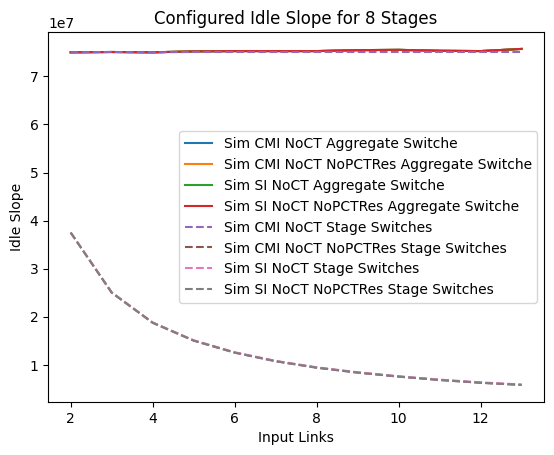

In [153]:
stages = 8
# plot the aggregate idle slopes from simAggregateIdleSlopes
fig, ax = plt.subplots()
for isScheme in simAggregateIdleSlopes:
    for ctScheme in simAggregateIdleSlopes[isScheme]:
        slopes = dict()
        for key in simAggregateIdleSlopes[isScheme][ctScheme]:
            if key[1] == stages:
                slopes[key[0]] = simAggregateIdleSlopes[isScheme][ctScheme][key]
        slopes = dict(sorted(slopes.items()))
        name = "Sim " + isScheme + ' ' + ctScheme.replace("_", " ") + ' Aggregate Switche'
        ax.plot(slopes.keys(), slopes.values(), label=name)
# add the stage slopes
for isScheme in simStageIdleSlopes:
    for ctScheme in simStageIdleSlopes[isScheme]:
        slopes = dict()
        for key in simStageIdleSlopes[isScheme][ctScheme]:
            if key[1] == stages:
                slopes[key[0]] = simStageIdleSlopes[isScheme][ctScheme][key]
        slopes = dict(sorted(slopes.items()))
        name = "Sim " + isScheme + ' ' + ctScheme.replace("_", " ") + ' Stage Switches'
        ax.plot(slopes.keys(), slopes.values(), label=name, linestyle='dashed')
ax.set_xlabel('Input Links')
ax.set_ylabel('Idle Slope')
ax.set_title('Configured Idle Slope for ' + str(stages) + ' Stages')
ax.legend()
plt.show()


## Delay Analysis for Input Links and 8 Stages

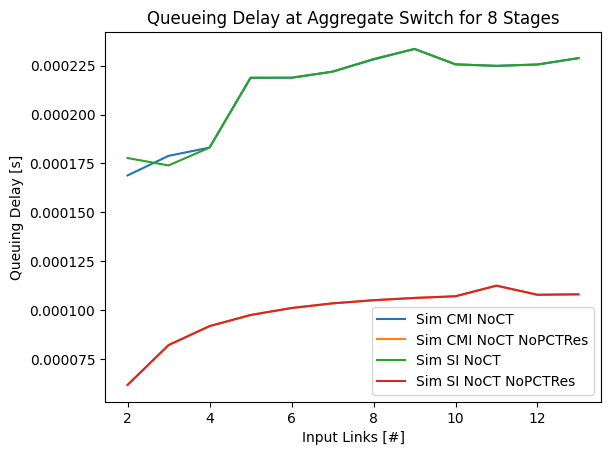

In [154]:
stages = 8
# plot the aggregate delays from simAggregateDelays
fig, ax = plt.subplots()
for isScheme in simAggregateDelays:
    for ctScheme in simAggregateDelays[isScheme]:
        delays = dict()
        for key in simAggregateDelays[isScheme][ctScheme]:
            if key[1] == stages:
                delays[key[0]] = simAggregateDelays[isScheme][ctScheme][key]
        delays = dict(sorted(delays.items()))
        name = "Sim " + isScheme + ' ' + ctScheme.replace("_", " ")
        ax.plot(delays.keys(), delays.values(), label=name)
ax.set_xlabel('Input Links [#]')
ax.set_ylabel('Queuing Delay [s]')
ax.set_title('Queueing Delay at Aggregate Switch for ' + str(stages) + ' Stages')
ax.legend()
plt.show()

## Delay Analysis for the Number of Stages and 13 Input Links

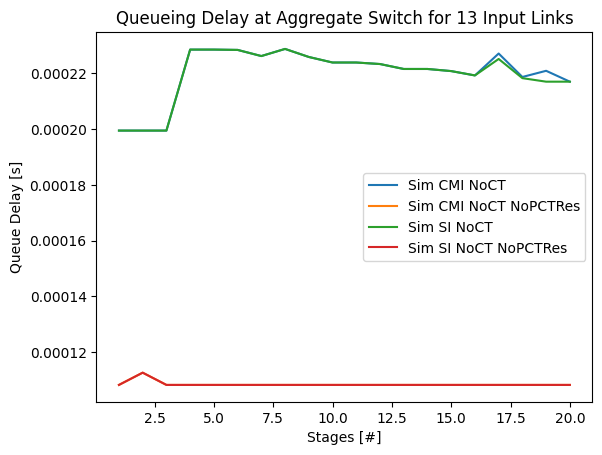

In [155]:
inputLinks = 13
# plot the aggregate delays from simAggregateDelays
fig, ax = plt.subplots()
for isScheme in simAggregateDelays:
    for ctScheme in simAggregateDelays[isScheme]:
        delays = dict()
        for key in simAggregateDelays[isScheme][ctScheme]:
            if key[0] == inputLinks:
                delays[key[1]] = simAggregateDelays[isScheme][ctScheme][key]
        delays = dict(sorted(delays.items()))
        name = "Sim " + isScheme + ' ' + ctScheme.replace("_", " ")
        ax.plot(delays.keys(), delays.values(), label=name)
ax.set_xlabel('Stages [#]')
ax.set_ylabel('Queue Delay [s]')
ax.set_title('Queueing Delay at Aggregate Switch for ' + str(inputLinks) + ' Input Links')
ax.legend()
plt.show()


# Export Results to CSV for Latex Plotting